In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import folium
# from folium.plugins import HeatMap
import branca

The data is obtained from https://at.govt.nz/about-us/reports-publications/traffic-counts/ and includes only records with coordinates. The coordinates were transfered from NZTM to longitude and latitude.

In [4]:
df = pd.read_csv(r'data/traffic-counts_v1.csv', parse_dates = ['Count Start Date'])
df.set_index('Count Start Date', inplace = True)
df.drop_duplicates(inplace = True)
display_all(df.head())
df.info()

,Road Name,Carriageway Start Name,Carriageway End Name,5 Day ADT,7 Day ADT,Saturday Volume,Sunday Volume,AM Peak Volume,AM Peak Hour,Mid Peak Volume,Mid Peak Hour,PM Peak Volume,PM Peak Hour,Car,LCV,MCV,HCV-I,HCV-II,HCV Total,latitude,longitude
Count Start Date,,,,,,,,,,,,,,,,,,,,,
2015-11-04,LADIES MILE (REMUERA),REMUERA RD,ORMONDE RD,11488.0,10346.0,8471.0,6513.0,1101,745.0,873,1400.0,1212,1700.0,0.95,0.01,0.02,0.01,0.00,0.03,-36.883006,174.809151
2016-05-05,GRANDE VUE RD (MANUREWA),MOTORWAY ONRAMP (END ISLAND LHS),HILL RD,17898.0,17580.0,17770.0,15795.0,1460,NaN,1393,NaN,1279,NaN,0.90,0.01,0.08,0.00,0.00,0.09,-37.014364,174.904840
2017-05-04,GRANDE VUE RD (MANUREWA),MOTORWAY ONRAMP (END ISLAND LHS),HILL RD,18810.0,18014.0,17674.0,14374.0,1572,NaN,1369,NaN,1343,NaN,0.91,0.01,0.07,0.01,0.00,0.08,-37.014364,174.904840
2017-12-14,ST LUKES RD,CORNWALLIS ST,SANDRINGHAM RD (LHS),29674.0,28867.0,28201.0,25499.0,1849,900.0,2355,1130.0,2372,1800.0,0.92,0.01,0.02,0.03,0.01,0.05,-36.884606,174.736356
2017-12-18,KAWAKAWA BAY COAST RD-HC-WK1,TE PAPA RD,END,167.0,200.0,301.0,269.0,18,845.0,41,NaN,39,NaN,0.94,0.02,0.04,0.00,0.00,0.04,-36.938205,175.182248


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2684 entries, 2015-11-04 to 2019-04-09
Data columns (total 21 columns):
Road Name                 2684 non-null object
Carriageway Start Name    2680 non-null object
Carriageway End Name      2683 non-null object
5 Day ADT                 2683 non-null float64
7 Day ADT                 2683 non-null float64
Saturday Volume           2684 non-null float64
Sunday Volume             2684 non-null float64
AM Peak Volume            2684 non-null int64
AM Peak Hour              561 non-null float64
Mid Peak Volume           2684 non-null int64
Mid Peak Hour             867 non-null float64
PM Peak Volume            2684 non-null int64
PM Peak Hour              683 non-null float64
Car                       2684 non-null float64
LCV                       2684 non-null float64
MCV                       2684 non-null float64
HCV-I                     2684 non-null float64
HCV-II                    2684 non-null float64
HCV Total              

In [5]:
# function for create a visualization
def create_visualization(df_, date_range_min_, date_rage_max_, col_, percentile = 80, radius = 10):
    colorscale = branca.colormap.linear.YlGnBu_09.scale(min(df_[col_]), max(df_[col_]))
    df_ = df_.loc[date_range_min_:date_rage_max_]
    df_ = df_[df_[col_] > np.nanpercentile(df_[col_], percentile)]
    
    m = folium.Map(location = [-36.848461, 174.763336])  #show Auckland
    for long, lat, volume, road in zip(df_['longitude'], df_['latitude'], df_[col_], df_['Road Name']):
        folium.CircleMarker(location=(lat, long),
                        popup = f'{road}:{volume}',
                        radius=radius,
                        color=colorscale(volume),
                        fill=True).add_to(m)
#     m.save('Auckland_map.html')
#    m._repr_html_()
    return m

# Questions to answer
- Traffic volume distribution/histogram (done)
- How does the traffic volume change over time/ how stable is the traffic volume? can they be used for future estimation?
    - groupby (longitude, latitude)
    - get max, min over time and calculate the maximum difference
    - identify drastic change of volume (outliers)
- Identify sites with the highest traffic volumes
- Pandas profiling on records with top traffic volumes



# Exploratory

## Date record histogram

The majority of the records are after 2018

In [6]:
df.shape

(2684, 21)

(array([  1.,   1.,   0.,   0.,   1.,   0., 575., 930., 706., 470.]),
 array([735906. , 736031.2, 736156.4, 736281.6, 736406.8, 736532. ,
        736657.2, 736782.4, 736907.6, 737032.8, 737158. ]),
 <a list of 10 Patch objects>)

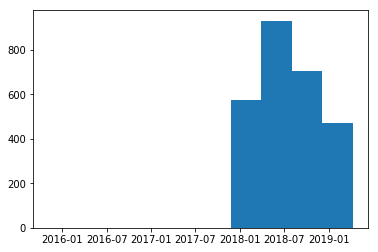

In [7]:
plt.hist(df.index)

In [8]:
df.index[df.index < '2018-01-01']
# only a few records before 2018,

DatetimeIndex(['2015-11-04', '2016-05-05', '2017-05-04', '2017-12-14',
               '2017-12-18', '2017-12-25'],
              dtype='datetime64[ns]', name='Count Start Date', freq=None)

In [9]:
# remove record before 2017-12
df = df[df.index > '2017-12-01']

## Check the frequency of traffic counts

In [24]:
temp = df[['longitude', 'latitude', '7 Day ADT', 'Road Name']].groupby(['longitude', 'latitude'])['7 Day ADT'].size().reset_index(name = 'count')

print((temp['count'] == 1).sum())
print((temp['count'] > 1).sum())
print((temp['count'] > 2).sum())

2202
219
29


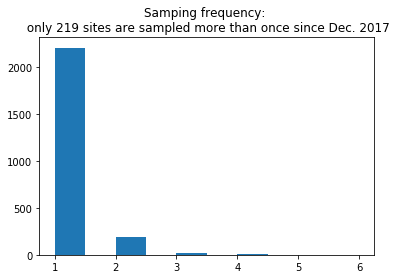

In [11]:
# check how often a place is sampled
plt.hist(df[['longitude', 'latitude', '7 Day ADT', 'Road Name']].groupby(['longitude', 'latitude']).size())
plt.title('Samping frequency: \n only 219 sites are sampled more than once since Dec. 2017')
plt.savefig('images\sampling_frequency.png')

Most places are sampled once or twice. List out places that are sampled more than two times

In [12]:
sample_count = df.groupby(['longitude', 'latitude', 'Road Name'])['latitude'].count().to_frame('count').reset_index()
count_more_than_1 = sample_count[sample_count['count']>1]
display_all(count_more_than_1.sort_values(by = 'count').tail())
count_more_than_1.shape

,longitude,latitude,Road Name,count
1104,174.738466,-37.263426,HULL RD (WAIUKU),2
1099,174.738171,-37.212778,MISSION BUSH RD,2
1007,174.730006,-37.136971,CLARKS BEACH RD,2
1926,174.860778,-36.957460,BAIRDS RD,3
2159,174.904840,-37.014364,GRANDE VUE RD (MANUREWA),4


(124, 4)

124 coordinates have more than 1 traffic count over the time periods included in the dataset.

Found out about ONRC Categories, which defines a minimum frequency for conducting traffic count based on road category (e.g. roads classified as "high volume to arterial" has a minimum traffic-count frequency of once per year)
https://nzta.govt.nz/assets/Road-Efficiency-Group/docs/Traffic-estimate-data-Overview.pdf

## Traffic volume histogram

From previous jupyter notebook we can see high correlation (both in pearson corr. or spearman corr.) between different traffic volume measures. Hense for the exploratory analysis, we simply focus on '7 Day ADT'.

count     2680.000000
mean      9404.418657
std       8412.181971
min         13.000000
25%       2127.250000
50%       7334.500000
75%      14845.000000
max      45272.000000
Name: 7 Day ADT, dtype: float64

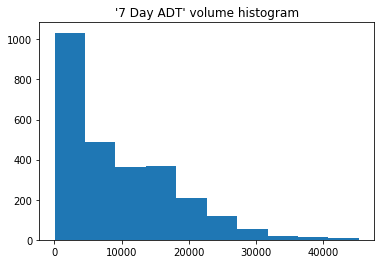

In [13]:
plt.hist(df['7 Day ADT'])
plt.title("'7 Day ADT' volume histogram")
plt.savefig('images/volume_histogram.png')
df['7 Day ADT'].describe()

In [14]:
# get the 90% percentile
print(np.nanpercentile(df['7 Day ADT'], 90), np.nanpercentile(df['7 Day ADT'], 99))

21533.100000000002 34171.47


## Change of traffic volume over time

In [15]:
df.reset_index(inplace = True)
df['count'] = df.groupby(['longitude', 'latitude'])['latitude'].transform('count')
df['first_sample_date'] = df.groupby(['longitude', 'latitude'])['Count Start Date'].transform('min')
df['last_sample_date'] = df.groupby(['longitude', 'latitude'])['Count Start Date'].transform('max')

(array([2202.,    0.,  380.,    0.,   57.,    0.,   36.,    0.,    0.,
           6.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

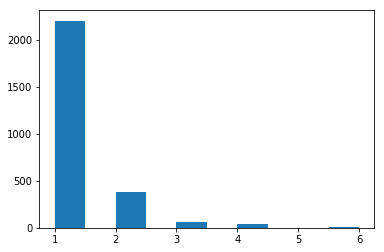

In [16]:
plt.hist(df['count'])
# most coordinates are sampled only once

In [17]:
df.columns

Index(['Count Start Date', 'Road Name', 'Carriageway Start Name',
       'Carriageway End Name', '5 Day ADT', '7 Day ADT', 'Saturday Volume',
       'Sunday Volume', 'AM Peak Volume', 'AM Peak Hour', 'Mid Peak Volume',
       'Mid Peak Hour', 'PM Peak Volume', 'PM Peak Hour', 'Car', 'LCV', 'MCV',
       'HCV-I', 'HCV-II', 'HCV Total', 'latitude', 'longitude', 'count',
       'first_sample_date', 'last_sample_date'],
      dtype='object')

In [18]:
# store only sites that are sampled more than once
df_sub = df[df['count']>1]
df_sub = df_sub.drop_duplicates(subset = ['longitude', 'latitude'])

df_sub.shape
# df_sub_temp = df_sub.drop_duplicates(subset = ['longitude', 'latitude'])

(219, 25)

(736677.0, 737158.0)

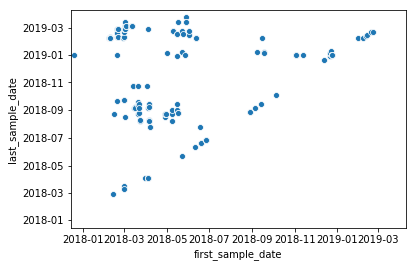

In [19]:
sns.scatterplot(x = 'first_sample_date', y = 'last_sample_date', data = df_sub)
plt.xlim(df['Count Start Date'].min(), df['Count Start Date'].max())
plt.ylim(df['Count Start Date'].min(), df['Count Start Date'].max())

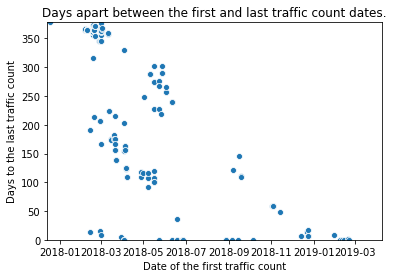

In [23]:
df_sub['time_apart'] = df_sub['last_sample_date'] - df_sub['first_sample_date']
df_sub['time_apart'] = df_sub['time_apart'].astype('timedelta64[D]').astype(int)

sns.scatterplot(x = 'first_sample_date', y = 'time_apart', data = df_sub)
plt.xlim(df['Count Start Date'].min(), df['Count Start Date'].max())
plt.ylim(df_sub['time_apart'].min(), df_sub['time_apart'].max())
plt.ylabel('Days to the last traffic count')
plt.xlabel('Date of the first traffic count')
plt.title('Days apart between the first and last traffic count dates.')
plt.savefig("images/days_apart.png")

We can see many records have a very short time between the two traffic counts, which is not useful for estimating traffic change over time. However, it maybe useful for estimating traffic count variation.

Near the top-left cornor there is a cluster where the last traffic counts are about 1 year apart from the first traffic count. Since they are about 1 year apart, these records would have minimal seasonal effects between them. We can use them to estimate the change of traffic volume.


In [39]:
df_sub['time_apart'].head()

1   378 days
5   364 days
6   364 days
8   364 days
9   364 days
Name: time_apart, dtype: timedelta64[ns]

In [39]:
df_sub2 = df_sub[df_sub['time_apart']>330]
print(df_sub2['first_sample_date'].max(), df_sub2['last_sample_date'].min())
# print(df_sub2.shape)
# df_sub2.columns

2018-03-12 00:00:00 2018-12-31 00:00:00


In [48]:
# subset df by date between Jan and March
# df_2018 = df[(df.index>'2018-01-01') & (df.index<'2018-04-01')]
# df_2019 = df[(df.index>'2019-01-01') & (df.index<'2019-04-01')]

In [42]:
df.set_index('Count Start Date', inplace = True)

In [50]:
df_2018 = df[df.index<'2018-03-13']
df_2019 = df[df.index>'2018-12-30']

In [51]:
# find out common coordinates
coord_2018 = set(zip(df_2018['longitude'], df_2018['latitude']))
coord_2019 = set(zip(df_2019['longitude'], df_2019['latitude']))
common_coord = coord_2018 & coord_2019
len(common_coord)

82

In [52]:
# plot change of traffic for these coord
# use the first traffic count and the last traffic count
df_2018 = df_2018[['longitude','latitude', '7 Day ADT']]
df_2019 = df_2019[['longitude','latitude', '7 Day ADT']]
df_2018.sort_index(inplace=True)
df_2019.sort_index(inplace=True)
df_2018.drop_duplicates(subset = ['longitude','latitude'], keep = 'first', inplace = True)
df_2019.drop_duplicates(subset = ['longitude','latitude'], keep = 'last', inplace = True)
df_2018.reset_index(inplace = True)
df_2019.reset_index(inplace = True)
df_merged = df_2018.merge(df_2019, how = 'inner', left_on = ['longitude','latitude'], right_on = ['longitude','latitude'], suffixes = ('_18','_19'))
df_merged.columns
# col_wanted = ['Count Start Date', '7 Day ADT']
# dates18 = []
# dates19 = []
# fig, ax = plt.subplots()
# for coord in common_coord:
#     record18 = df_2018.loc[(df_2018['longitude'] == coord[0])&(df_2018['latitude'] == coord[1]), col_wanted]
#     record19 = df_2019.loc[(df_2019['longitude'] == coord[0])&(df_2019['latitude'] == coord[1]), col_wanted]
#     dates = [record18.index[0], record19.index[0]]
#     volumes = [record18['7 Day ADT'][0], record19['7 Day ADT'][0]]
#     sns.lineplot(x = dates, y = volumes)


Index(['Count Start Date_18', 'longitude', 'latitude', '7 Day ADT_18',
       'Count Start Date_19', '7 Day ADT_19'],
      dtype='object')

In [53]:
df_merged['percentage_vol_diff'] = df_merged.apply(lambda row: (row['7 Day ADT_19'] - row['7 Day ADT_18'])/row['7 Day ADT_18'], axis = 1)
df_merged['vol_diff'] = df_merged['7 Day ADT_19'] - df_merged['7 Day ADT_18']

In [54]:
df_merged['percentage_vol_diff'].describe()

count    82.000000
mean      0.038190
std       0.244060
min      -0.397260
25%      -0.014803
50%       0.015042
75%       0.065151
max       1.810000
Name: percentage_vol_diff, dtype: float64

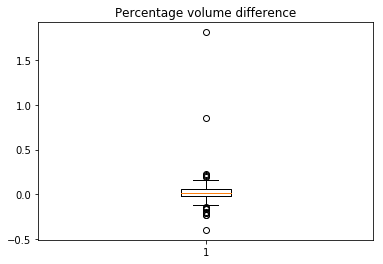

In [69]:
plt.boxplot(df_merged['percentage_vol_diff'])
plt.title('Percentage volume difference')
plt.savefig('images\percent_volume_difference.png')

In [56]:
# take a look at the outliers
df_merged[abs(df_merged['percentage_vol_diff'])>0.2]

,Count Start Date_18,longitude,latitude,7 Day ADT_18,Count Start Date_19,7 Day ADT_19,percentage_vol_diff,vol_diff
0,2017-12-18,175.182248,-36.938205,200.0,2018-12-31,562.0,1.810000,362.0
21,2018-02-09,174.750848,-37.220072,872.0,2019-02-09,686.0,-0.213303,-186.0
41,2018-02-18,174.678838,-37.273183,1043.0,2018-12-31,1281.0,0.228188,238.0
42,2018-02-18,174.616338,-37.171484,47.0,2019-02-19,36.0,-0.234043,-11.0
44,2018-02-19,174.649713,-37.056943,251.0,2019-02-19,199.0,-0.207171,-52.0
45,2018-02-19,174.608464,-37.115591,1304.0,2019-02-19,2416.0,0.852761,1112.0
50,2018-02-19,174.571815,-37.110026,73.0,2019-02-19,44.0,-0.397260,-29.0
55,2018-02-19,174.608391,-37.066894,81.0,2019-02-19,62.0,-0.234568,-19.0
57,2018-02-20,174.810508,-37.215660,1084.0,2019-02-26,1307.0,0.205720,223.0
72,2018-03-02,174.935204,-37.157925,340.0,2019-03-05,413.0,0.214706,73.0


Plot change of volume

In [ ]:
branca.colormap.linear.Paired_08

In [71]:
m = folium.Map(location = [-37.144312, 174.729056])  #show Clarks beach
radius = 5
#    YlGnBu_09
colorscale = branca.colormap.linear.Paired_08.scale(min(df_merged['percentage_vol_diff']), max(df_merged['percentage_vol_diff']))
for long, lat, pvd, vd in zip(df_merged['longitude'], df_merged['latitude'], df_merged['percentage_vol_diff'], df_merged['vol_diff']):
    folium.CircleMarker(location=(lat, long),
                        popup = f'vol. diff.:{vd}, percent vol. diff.:{pvd}',
                        radius=radius,
                        color=colorscale(pvd),
                        fill=True).add_to(m)

m.save('images\perc_vol_diff.html')

In [72]:
m

Most data are for south of Auckland so we cannot draw valid conclusion about the change of traffic volume without seasonal effects... 

# Look at other data